In [89]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
devicharith_language_translation_englishfrench_path = kagglehub.dataset_download('devicharith/language-translation-englishfrench')

print('Data source import complete.')


Data source import complete.


In [90]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eng_-french.csv


# Data preprocesing

In [91]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM,Input,Embedding,TimeDistributed,Dense,AdditiveAttention,Concatenate

In [92]:
data = pd.read_csv("/kaggle/input/eng_-french.csv")

In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175621 entries, 0 to 175620
Data columns (total 2 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   English words/sentences  175621 non-null  object
 1   French words/sentences   175621 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


In [94]:
data.head()

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [95]:
data.isna().sum()

English words/sentences    0
French words/sentences     0
dtype: int64

In [96]:
data = data.rename(columns={"English words/sentences":"english","French words/sentences":"french"})
data.head()

,english,french
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [97]:
french_text_len = [len(text.split(" ")) for text in data["french"]]
english_text_len = [len(text.split(" ")) for text in data["english"]]
longest_french_seq = max(french_text_len)
longest_english_seq = max(english_text_len)
longest_english_seq,longest_french_seq

(44, 55)

In [98]:
def data_preprocessing(data_point):
    eng_text = tf.strings.strip(data_point["english"])
    french_text = tf.strings.strip(data_point["french"])
    sos = tf.constant("<SOS>")
    eos = tf.constant("<EOS>")
    french_text = tf.strings.join([sos,french_text,eos],separator=" ")
    return {"english":eng_text,"french":french_text}

In [99]:
tf_dataset = tf.data.Dataset.from_tensor_slices(dict(data))
tf_dataset = tf_dataset.map(data_preprocessing,num_parallel_calls=tf.data.AUTOTUNE)
len(tf_dataset)

175621

In [100]:
test_data = tf_dataset.take(5)
for data_point in test_data:
    print({k:v.numpy() for k,v in data_point.items()})

{'english': b'Hi.', 'french': b'<SOS> Salut! <EOS>'}
{'english': b'Run!', 'french': b'<SOS> Cours\xe2\x80\xaf! <EOS>'}
{'english': b'Run!', 'french': b'<SOS> Courez\xe2\x80\xaf! <EOS>'}
{'english': b'Who?', 'french': b'<SOS> Qui ? <EOS>'}
{'english': b'Wow!', 'french': b'<SOS> \xc3\x87a alors\xe2\x80\xaf! <EOS>'}


In [101]:
raw_data = [
    {'english': b'Hi.', 'french': b'<SOS> Salut! <EOS>'},
    {'english': b'Run!', 'french': b'<SOS> Cours\xe2\x80\xaf! <EOS>'},
    {'english': b'Run!', 'french': b'<SOS> Courez\xe2\x80\xaf! <EOS>'},
    {'english': b'Who?', 'french': b'<SOS> Qui ? <EOS>'},
    {'english': b'Wow!', 'french': b'<SOS> \xc3\x87a alors\xe2\x80\xaf! <EOS>'}
]

# Create a tf.data.Dataset from your data
# We'll extract just the French sentences for this demo
french_sentences_bytes = [item['french'] for item in raw_data]
dataset = tf.data.Dataset.from_tensor_slices(french_sentences_bytes)

In [102]:
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(standardize='lower_and_strip_punctuation')
vectorizer.adapt(dataset)
vectorizer.get_vocabulary()

['',
 '[UNK]',
 'sos',
 'eos',
 'Ça',
 'salut',
 'qui',
 'cours\u202f',
 'courez\u202f',
 'alors\u202f']

In [103]:
english_vectorizer = tf.keras.layers.TextVectorization()
french_vectorizer = tf.keras.layers.TextVectorization()

for batch in tf_dataset.batch(len(tf_dataset)):
    english_vectorizer.adapt(batch["english"])
    french_vectorizer.adapt(batch["french"])

english_vocab,french_vocab = len(english_vectorizer.get_vocabulary()),len(french_vectorizer.get_vocabulary())
english_vocab,french_vocab

(14672, 33384)

In [104]:
def vectorization_func(x):
    english_vec = english_vectorizer(x["english"])
    french_vec = french_vectorizer(x["french"])
    french_input = french_vec[:-1]
    french_target = tf.reshape(french_vec[1:],(-1,1))
    return ({"english":english_vec,"french_input":
            french_input},french_target)

In [105]:
tf_dataset_vectorized = tf_dataset.map(vectorization_func, num_parallel_calls=tf.data.AUTOTUNE)
tf_dataset_vectorized = tf_dataset_vectorized.shuffle(1000000)
dataset_size = len(tf_dataset_vectorized)
train_size = int(dataset_size*0.8)
train = tf_dataset_vectorized.take(train_size)
test = tf_dataset_vectorized.skip(train_size)
print(f"Train size {train_size} actual length {len(train)}")
test_size = dataset_size-train_size
val_size = int((dataset_size-train_size)*0.5)
test_size = (dataset_size-train_size)-val_size
val = test.skip(test_size)
test = test.take(test_size)
print(f"Test size {test_size} actual length {len(test)}")
print(f"val size {val_size} actual length {len(val)}")

Train size 140496 actual length 140496
Test size 17563 actual length 17563
val size 17562 actual length 17562


In [106]:
padded_shapes = (
    {
        "english":[None],
        "french_input":[None]
    },
    [None,1]
)

In [107]:
batch_size = 512

In [108]:
train = train.shuffle(100000).padded_batch(batch_size=batch_size, padded_shapes=padded_shapes).prefetch(tf.data.AUTOTUNE)
val = val.padded_batch(batch_size=batch_size, padded_shapes=padded_shapes).prefetch(tf.data.AUTOTUNE)
test = test.padded_batch(batch_size=1, padded_shapes=padded_shapes).prefetch(tf.data.AUTOTUNE)

# building custom attention layers

In [109]:
from tensorflow.keras.layers import Layer

class BahdanauAttention(Layer):
    def __init__(self,units):
        super().__init__()
        self.w1 = Dense(units)
        self.w2 = Dense(units)
        self.v = Dense(1)
    def call(self,query,values):
        # query shape (batch,dec_seq,units)
        # values shape (batch,enc_seq,units)
        # after expanding shape (batch,dec_seq,1,units) , (batch,1,enc_seq,units)
        query = tf.expand_dims(query,axis=2)
        values = tf.expand_dims(values,axis=1)

        # result shape (batch,dec_seq,enc_seq,units)
        result = tf.math.tanh(self.w1(query)+self.w2(values))

        #score in shape (batch,dec_seq,enc_seq,1)
        score = self.v(result)

        # applying softmax in enc_seq
        attention_weights = tf.nn.softmax(score,axis=2)
        # applying attention weights of shape (batch,dec_seq,enc_seq,1) in values of shape (batch,1,enc_seq,units)
        # gives (batch,dec_seq,enc_seq,units)
        context_vector = attention_weights*values

        # gives shape (batch,dec_seq,units)
        context_vector = tf.reduce_sum(context_vector,axis=2)

        return context_vector,attention_weights




In [110]:
class LuongAttention(Layer):
    def __init__(self):
        super().__init__()

    def call(self,query,values):
        # query shape (batch,dec_seq,units)
        # values shape (batch,enc_seq,units)
        # for dot similarity of 2 matrix we do matrix multiplication of transpose
        # values_transposed (batch,units,enc_seq)
        values_transposed = tf.transpose(values,perm=[0,2,1])

        # score shape (batch,dec_seq,enc_seq)
        score = tf.matmul(query,values_transposed)

        attention_weights = tf.nn.softmax(score,axis=-1)

        # shape (batch,dec_seq,units)
        contex_vector = tf.matmul(attention_weights,values)

        return contex_vector, attention_weights

# building Encoder - Decoder

In [111]:
latent_dim = 512
embedding_dim = 300

In [112]:
strategy = tf.distribute.MirroredStrategy()
print(f'Number of devices: {strategy.num_replicas_in_sync}')

Number of devices: 1


## Encoder

In [113]:
encoder_input = Input((None,))
encoder_embedding = Embedding(english_vocab,embedding_dim,trainable=True)(encoder_input)
encoder_lstm1 = LSTM(latent_dim,return_state=True,return_sequences=True)
encoder_lstm2 = LSTM(latent_dim,return_state=True,return_sequences=True)
encoder_output1,_ ,_ = encoder_lstm1(encoder_embedding)
encoder_output, encoder_state_h, encoder_state_c = encoder_lstm2(encoder_output1)

## decoder

In [114]:
decoder_input = Input((None,))
decoder_embedding_layer = Embedding(french_vocab,embedding_dim,trainable=True)
decoder_embedding = decoder_embedding_layer(decoder_input)
decoder_lstm = LSTM(latent_dim,return_sequences=True,return_state=True)
decoder_lstm_output, _, _ = decoder_lstm(decoder_embedding,initial_state=[encoder_state_h, encoder_state_c])
# decoder_attention = AdditiveAttention()([decoder_lstm_output,encoder_output])
# decoder_attention,_ = BahdanauAttention(latent_dim)(decoder_lstm_output,encoder_output)
decoder_attention,_ = LuongAttention()(decoder_lstm_output,encoder_output)
decoder_concat_input = Concatenate(axis=-1)([decoder_lstm_output,decoder_attention])
decoder_dropout_input = tf.keras.layers.Dropout(0.3)(decoder_concat_input)
decoder_dense = TimeDistributed(Dense(french_vocab))
decoder_dense_output = decoder_dense(decoder_dropout_input)

# encoder-decoder model

In [115]:
model = tf.keras.Model(inputs={"english":encoder_input,"french_input":decoder_input},outputs=[decoder_dense_output])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_6 (Embedding)   │ (None, None, 300)      │      4,401,600 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_10            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_9 (LSTM)             │ [(None, None, 512),    │      1,665,024 │ embedding_6[0][0]      │
│                           │ (None, 512), (None,    │                │                        │
│                           │ 512)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_7 (Embedding)   │ (None, None, 300)      │     10,015,200 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_10 (LSTM)            │ [(None, None, 512),    │      2,099,200 │ lstm_9[0][0]           │
│                           │ (None, 512), (None,    │                │                        │
│                           │ 512)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_11 (LSTM)            │ [(None, None, 512),    │      1,665,024 │ embedding_7[0][0],     │
│                           │ (None, 512), (None,    │                │ lstm_10[0][1],         │
│                           │ 512)]                  │                │ lstm_10[0][2]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ luong_attention_4         │ [(None, None, 512),    │              0 │ lstm_11[0][0],         │
│ (LuongAttention)          │ (None, None, None)]    │                │ lstm_10[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, None, 1024)     │              0 │ lstm_11[0][0],         │
│ (Concatenate)             │                        │                │ luong_attention_4[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, None, 1024)     │              0 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_3        │ (None, None, 33384)    │     34,218,600 │ dropout_3[0][0]        │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 54,064,648 (206.24 MB)

 Trainable params: 54,064,648 (206.24 MB)

 Non-trainable params: 0 (0.00 B)

In [116]:
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.callbacks import EarlyStopping

epochs = 50

loss = SparseCategoricalCrossentropy(from_logits=True)
scheduler = PolynomialDecay(
    initial_learning_rate=1e-3,
    decay_steps = epochs*len(train),
    end_learning_rate = 0
)

optimizer = AdamW(learning_rate=scheduler)

early_stopping = EarlyStopping(patience=3)

In [117]:
model.compile(optimizer=optimizer,loss=loss,metrics=["accuracy"])
history = model.fit(train,epochs=epochs,validation_data=val,verbose=1,callbacks=[early_stopping])

Epoch 1/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 196s 630ms/step - accuracy: 0.6903 - loss: 2.8273 - val_accuracy: 0.7279 - val_loss: 1.8299
Epoch 2/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 187s 619ms/step - accuracy: 0.7347 - loss: 1.7502 - val_accuracy: 0.7736 - val_loss: 1.3765
Epoch 3/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 187s 621ms/step - accuracy: 0.7679 - loss: 1.4047 - val_accuracy: 0.7835 - val_loss: 1.2354
Epoch 4/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 186s 615ms/step - accuracy: 0.7879 - loss: 1.2076 - val_accuracy: 0.7996 - val_loss: 1.0760
Epoch 5/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 188s 622ms/step - accuracy: 0.8026 - loss: 1.0661 - val_accuracy: 0.8290 - val_loss: 0.8703
Epoch 6/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 189s 625ms/step - accuracy: 0.8247 - loss: 0.8961 - val_accuracy: 0.8439 - val_loss: 0.7517
Epoch 7/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 189s 624ms/step - accuracy: 0.8416 - loss: 0.7688 - val_accuracy: 0.8660 - val_loss: 0.6192
Epoch 8/50
275/275 ━━━━━━━━━━━━━━━━━━━━ 187s 620ms/step - accuracy: 0.8613 -

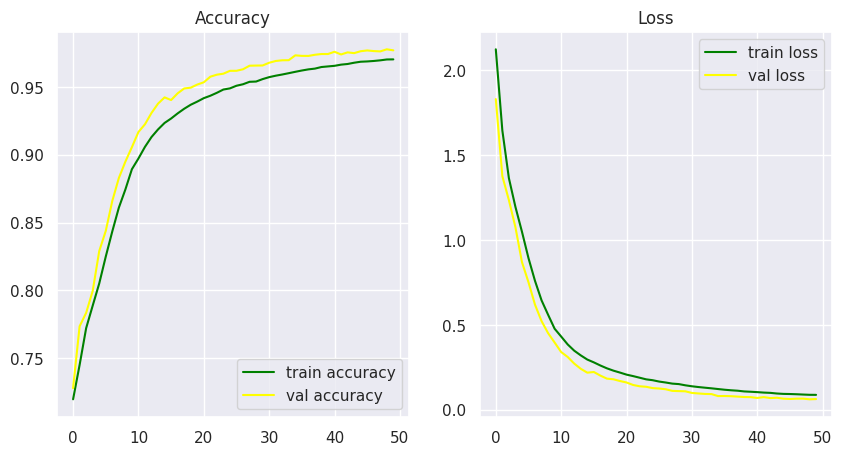

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

figure, axes = plt.subplots(1,2,figsize=(10,5))

train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
training_steps = range(len(train_acc))

sns.lineplot(x=training_steps,y=train_acc,color="green",ax=axes[0],label="train accuracy")
sns.lineplot(x=training_steps,y=val_acc,color="yellow",ax=axes[0],label="val accuracy")
axes[0].set_title("Accuracy")
sns.lineplot(x=training_steps,y=train_loss,color="green",ax=axes[1],label="train loss")
sns.lineplot(x=training_steps,y=val_loss,color="yellow",ax=axes[1],label="val loss")
axes[1].set_title("Loss")
plt.show()

# Building seperate enoder and decoder model for inference

In [119]:
encoder = tf.keras.Model(encoder_input,[encoder_output, encoder_state_h, encoder_state_c])
encoder.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_6 (Embedding)              │ (None, None, 300)           │       4,401,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ [(None, None, 512), (None,  │       1,665,024 │
│                                      │ 512), (None, 512)]          │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ [(None, None, 512), (None,  │       2,099,200 │
│                                      │ 512), (None, 512)]          │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,165,824 (31.15 MB)

 Trainable params: 8,165,824 (31.15 MB)

 Non-trainable params: 0 (0.00 B)

In [120]:
decoder_state_h_input = Input((latent_dim,))
decoder_state_c_input = Input((latent_dim,))
encoder_output_inference = Input((None,latent_dim))
decoder_inference_embedding = decoder_embedding_layer(decoder_input)
decoder_lstm_inference_output, decoder_inference_state_h, decoder_inference_state_c = decoder_lstm(decoder_inference_embedding,initial_state=[decoder_state_h_input, decoder_state_c_input])
# decoder_attention_inference = AdditiveAttention()([decoder_lstm_inference_output,encoder_output_inference])
# decoder_attention_inference,_ = BahdanauAttention(latent_dim)(decoder_lstm_inference_output,encoder_output_inference)
decoder_attention_inference,_ = LuongAttention()(decoder_lstm_inference_output,encoder_output_inference)
decoder_concat_inference = Concatenate(axis=-1)([decoder_lstm_inference_output,decoder_attention_inference])
decoder_dense_inference_output = decoder_dense(decoder_concat_inference)

In [121]:
decoder = tf.keras.Model([decoder_input,decoder_state_h_input, decoder_state_c_input,encoder_output_inference],[decoder_dense_inference_output,decoder_inference_state_h, decoder_inference_state_c])
decoder.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_7 (Embedding)   │ (None, None, 300)      │     10,015,200 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_11            │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_12            │ (None, 512)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_11 (LSTM)            │ [(None, None, 512),    │      1,665,024 │ embedding_7[1][0],     │
│                           │ (None, 512), (None,    │                │ input_layer_11[0][0],  │
│                           │ 512)]                  │                │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_13            │ (None, None, 512)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ luong_attention_5         │ [(None, None, 512),    │              0 │ lstm_11[1][0],         │
│ (LuongAttention)          │ (None, None, None)]    │                │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, None, 1024)     │              0 │ lstm_11[1][0],         │
│ (Concatenate)             │                        │                │ luong_attention_5[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_3        │ (None, None, 33384)    │     34,218,600 │ concatenate_5[0][0]    │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 45,898,824 (175.09 MB)

 Trainable params: 45,898,824 (175.09 MB)

 Non-trainable params: 0 (0.00 B)

# Inference

In [122]:
english_token_to_text = english_vectorizer.get_vocabulary()
french_token_to_text = french_vectorizer.get_vocabulary()


In [123]:
def decoder_inference(input_seq):

    encoder_output,state_value_h,state_value_c = encoder.predict(input_seq,verbose=0)

    target_seq = np.zeros((1,1))
    target_seq[0,0] = french_vectorizer("<SOS>").numpy()

    stop_condition = True

    decoded_sentence = ""

    while(stop_condition):

        output_token,state_value_h,state_value_c = decoder.predict([target_seq,state_value_h,state_value_c,encoder_output],verbose=0)
        output_word = french_token_to_text[output_token[0,0,:].argmax()]
        decoded_sentence = (decoded_sentence + " " + output_word) if (not output_word == "eos") else decoded_sentence
        target_seq[0,0] =  output_token[0,0,:].argmax()

        if output_word == "eos" or len(decoded_sentence.split(" ")) > longest_french_seq:
            stop_condition = False

    return decoded_sentence

In [124]:
def translate(input_seq):
  batch_size = input_seq.shape[0]
  encoder_output, state_value_h, state_value_c = encoder.predict(input_seq,verbose=0)
  target_seq = np.ones((batch_size,1))*french_vectorizer("<SOS>").numpy()
  active = np.ones((batch_size),dtype=bool)
  decoded_sentences = [[] for _ in range(batch_size)]
  for _ in range(longest_french_seq+5):
    decoder_preds, state_value_h, state_value_c = decoder.predict([target_seq,state_value_h,state_value_c,encoder_output],verbose=0)
    target_seq = decoder_preds.argmax(axis=-1)

    for i in range(batch_size):
      output_token = french_token_to_text[target_seq[i,0]]
      if (output_token != "eos") and (active[i]==True):
        decoded_sentences[i].append(output_token)

      if (output_token=="eos") and (active[i]==True):
        active[i] = False

  return [" ".join(text) for text in decoded_sentences]

In [125]:
for features,target in test.take(20):
    english_words = [english_token_to_text[token] for token in features["english"][0].numpy()]
    english_text = " ".join(english_words)
    french_words = [french_token_to_text[token] for token in features["french_input"][0,1:].numpy()]
    french_text = " ".join(french_words)
    decoded_sentence = decoder_inference(features["english"])
    print(f"Input: {english_text}")
    print(f"Decoded: {decoded_sentence}")
    print(f"Expected: {french_text}")
    print("-" * 20)

Input: her beauty is incomparable
Decoded:  sa beauté est morte de elle
Expected: sa beauté est incomparable
--------------------
Input: ive been impressed with toms work
Decoded:  jai été impressionné par le tableau de tom
Expected: jai été impressionné par le travail de tom
--------------------
Input: i drive everywhere
Decoded:  conduis je conduis à lextérieur
Expected: je conduis partout
--------------------
Input: i just love that kind of stuff
Decoded:  jadore ce genre de trucs de trucs sont simplement
Expected: jadore ce genre de choses
--------------------
Input: im eating everything
Decoded:  manger de manger
Expected: je mange tout
--------------------
Input: im so proud of you
Decoded:  je suis tellement fier de toi
Expected: je suis tellement fière de toi
--------------------
Input: tom had a knife in his hand
Decoded:  tom avait un couteau dans sa couteau
Expected: tom avait un couteau dans la main
--------------------
Input: he was every inch a king
Decoded:  il a été un 

In [126]:
!pip install -q evaluate
import evaluate
metric = evaluate.load("bleu")

In [127]:

test = test.unbatch().padded_batch(batch_size,padded_shapes=padded_shapes)
for features, target in test:
  actual_translation = []
  for label in features["french_input"]:
    french_words = []
    for token in label[1:].numpy():
        if token == 0:
            break
        french_words.append(french_token_to_text[token])
    french_text  = " ".join(french_words)
    actual_translation.append(french_text)
  predicted_translation=translate(features["english"])
  metric.add_batch(predictions=predicted_translation,references=actual_translation)

In [128]:
metric.compute()

{'bleu': 0.7620705155020685,
 'precisions': [0.8639537133109403,
  0.7843661283445816,
  0.7270277484714825,
  0.6864062855102107],
 'brevity_penalty': 0.9993319503782168,
 'length_ratio': 0.9993321734240171,
 'translation_length': 113726,
 'reference_length': 113802}

In [129]:
from pathlib import Path
MODEL_DIR = Path("models")
MODEL_DIR.mkdir(parents=True,exist_ok=True)

encoder_path = MODEL_DIR / "encoder.keras"
decoder_path = MODEL_DIR / "decoder.keras"

encoder.save(encoder_path)
decoder.save(decoder_path)

In [134]:
VECTORIZERS = Path("vectorizer")
VECTORIZERS.mkdir(parents=True,exist_ok=True)

vectorizer_path = VECTORIZERS / "vectorizers.keras"

vectorizers = tf.keras.Sequential([
    english_vectorizer,
    french_vectorizer
])

vectorizers.save(vectorizer_path)

In [140]:
loaded_vectorizers = tf.keras.models.load_model(vectorizer_path)
loaded_english_vectorizer =  loaded_vectorizers.layers[0]
print(loaded_english_vectorizer("hello world"))
loaded_french_vectorizer =  loaded_vectorizers.layers[1]
print(loaded_french_vectorizer("jadore ce genre de choses"))

tf.Tensor([1724  386], shape=(2,), dtype=int64)
tf.Tensor([449  17 498   5 214], shape=(5,), dtype=int64)
